In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image

In [2]:
# Path to file (for Colab)
PATH = ""

# Dataset
<a href="https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data">Amazon Dataset</a>

# Data Understanding

In [3]:
# See the shape of all images:
# Main Directory
main_path = PATH + 'AmazonDataset/'


def get_size(folder):
    sizes = []
    # Get from main directory all sub-directories
    for folder_path in os.listdir(folder):
        # Skip
        if (folder_path == '.DS_Store'):
            continue
        # See Train and Test sub-directories
        for folder_name in os.listdir(os.path.join(folder, folder_path)):
            # Skip
            if (folder_name in ['.DS_Store', 'test_v2_file_mapping.csv', 'train_v2.csv']):
                continue
            print(folder_name)
            for filename in os.listdir(os.path.join(folder, folder_path, folder_name)):
                
                # take image
                img = Image.open(os.path.join(folder, folder_path, folder_name, filename))
                # Get image with 
                #print(img.size)
                # Stores data like: (width, height)
                sizes.append(img.size)
            
    print(f'the max width is: {max(sizes[0])}, and the min width is: {min(sizes[0])}')
    print(f'the max height is: {max(sizes[1])}, and the min height is: {min(sizes[1])}')
    print(f'the mean width is: {np.mean(sizes[0])}, and the mean height is: {np.mean(sizes[1])}')

# Call the function
get_size(main_path)

test-jpg
train-jpg
the max width is: 256, and the min width is: 256
the max height is: 256, and the min height is: 256
the mean width is: 256.0, and the mean height is: 256.0


In [4]:
train_path = PATH + 'AmazonDataset/Train/'
test_path = PATH + 'AmazonDataset/Test/'

## See Images

In [5]:
images_folder_train = train_path + '/train-jpg/'
images_folder_test = test_path + '/test-jpg/'

In [6]:
import matplotlib.pyplot as plt
def plot_images(axis=(2,2), images_folder_path=images_folder_train, train = True):
    
    if train:
        train = 'train_'
    else:
        train = 'test_'
        
    # Grid
    f, axarr = plt.subplots(axis[0], axis[1], figsize=(30/axis[1], 10))
    
    for i in range(0,axis[0]):
        for j in range (0,axis[1]):
            # Choose a random image
            index_img = np.random.randint(100)
            filename = images_folder_path + train + str(index_img) + '.jpg'
            # Read Image:
            img = Image.open(filename).convert('RGB')
            # To numpy
            img = np.asarray(img)
            # Plot
            axarr[i,j].imshow(img)
    plt.show()

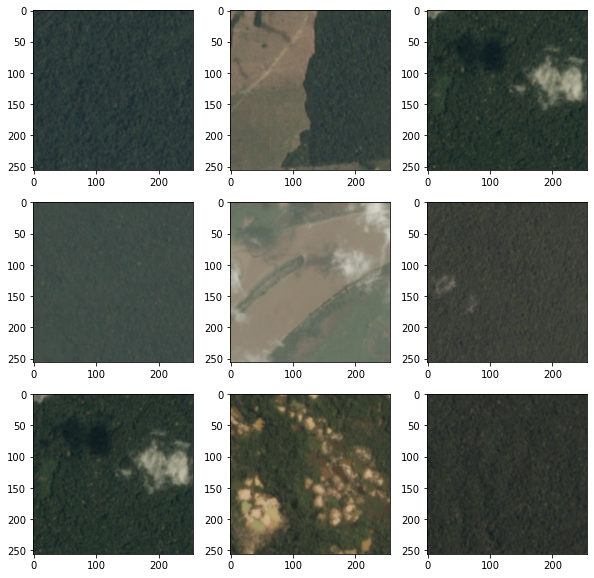

In [7]:
plot_images(axis=(3,3), images_folder_path=images_folder_train)

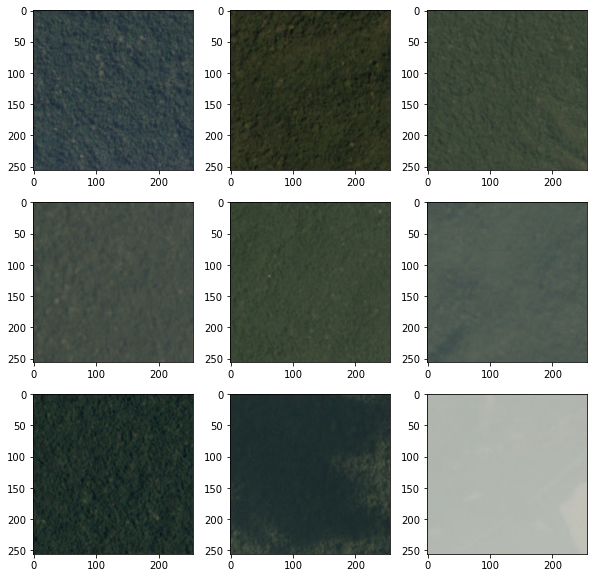

In [8]:
plot_images(axis=(3,3), images_folder_path=images_folder_test, train=False)

## See Labels

In [9]:
train_path_labels = train_path + 'train_v2.csv'
test_path_labels = test_path + 'test_v2_file_mapping.csv'

In [10]:
# Train Images and labels
train_map = pd.read_csv(train_path_labels)
train_map

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [11]:
pd.read_csv(test_path_labels)

,old,new
0,file_4158.tif,file_18830.tif
1,file_1668.tif,file_19164.tif
2,file_2411.tif,file_15749.tif
3,file_16047.tif,file_7531.tif
4,file_1271.tif,file_18347.tif
...,...,...
20517,file_17774.tif,file_14520.tif
20518,file_3538.tif,file_6633.tif
20519,file_1923.tif,file_4685.tif
20520,file_14047.tif,file_14571.tif


# Create Dataset
* This is a multi labels task, so we need binary encode the tags
* We don't have labels for testing images so we need to split data of train in train and test
* We have many information so we need a data loader to wrap-up the data and avoid overload the GPU or RAM

## Binary Encode

In [12]:
tags_encode = train_map.tags.str.get_dummies(sep=' ').columns
tags_encode

Index(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down',
       'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation',
       'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging',
       'slash_burn', 'water'],
      dtype='object')

In [13]:
# Select Tags
list_tags = ['agriculture', 'bare_ground', 'cultivation', 'habitation', 'primary', 'road', 'water']

## Filter images with tags 
* We have many tags, but we just want images with tags in list_tags so we filter

In [14]:
def filter_item(tag_string):
    res = any(tag in tag_string for tag in list_tags)
    return res    

In [15]:
train_map = train_map[train_map.tags.apply(lambda tag_string: filter_item(tag_string))]
train_map

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40473,train_40473,agriculture clear habitation primary road
40474,train_40474,clear primary
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


## Binary Encode and desired columns 

In [16]:
# Binary Encode
encode = train_map.tags.str.get_dummies(sep=' ')
train_map = pd.concat([train_map, encode], axis=1)
train_map.drop(columns=["tags"], inplace=True)
list_tags.insert(0,'image_name')
train_map = train_map[list_tags]
list_tags.pop(0)
train_map

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
0,train_0,0,0,0,0,1,0,0
1,train_1,1,0,0,0,1,0,1
2,train_2,0,0,0,0,1,0,0
3,train_3,0,0,0,0,1,0,0
4,train_4,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...
40473,train_40473,1,0,0,1,1,1,0
40474,train_40474,0,0,0,0,1,0,0
40476,train_40476,1,0,0,0,1,0,0
40477,train_40477,1,0,0,0,1,1,0


### Add ".jpg" to image name

In [17]:
train_map.image_name = train_map.image_name.apply(lambda name: name + '.jpg')
train_map

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
0,train_0.jpg,0,0,0,0,1,0,0
1,train_1.jpg,1,0,0,0,1,0,1
2,train_2.jpg,0,0,0,0,1,0,0
3,train_3.jpg,0,0,0,0,1,0,0
4,train_4.jpg,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...
40473,train_40473.jpg,1,0,0,1,1,1,0
40474,train_40474.jpg,0,0,0,0,1,0,0
40476,train_40476.jpg,1,0,0,0,1,0,0
40477,train_40477.jpg,1,0,0,0,1,1,0


the images with agriculture are 12315
the images with bare_ground are 862
the images with cultivation are 4477
the images with habitation are 3660
the images with primary are 37513
the images with road are 8071
the images with water are 7411


<AxesSubplot:>

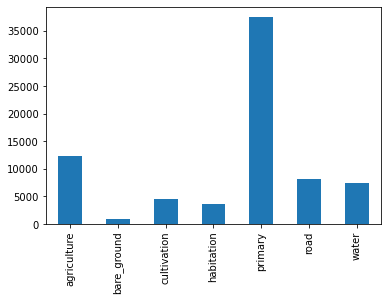

In [18]:
for item in list_tags:
    print(f'the images with {item} are {len(train_map[train_map[item] == 1])}')

train_map[list_tags].sum().plot.bar()

# Train, Test, Validation Split

In [19]:
from sklearn.model_selection import train_test_split

# Split Train and test
train, test = train_test_split(train_map, test_size=0.2, random_state=1)

# Split Train and validation
train, validation = train_test_split(train_map, test_size=0.1, random_state=1)

In [20]:
train

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
23491,train_23491.jpg,1,0,0,0,1,0,1
6046,train_6046.jpg,1,0,0,0,1,1,0
8878,train_8878.jpg,1,0,1,0,1,0,0
26987,train_26987.jpg,1,0,0,0,1,0,0
4478,train_4478.jpg,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
8247,train_8247.jpg,0,0,0,0,1,0,0
34311,train_34311.jpg,0,0,0,0,1,1,1
5486,train_5486.jpg,0,0,0,0,1,0,0
12866,train_12866.jpg,1,0,0,0,1,0,0


In [21]:
test

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
16249,train_16249.jpg,1,0,0,0,1,1,0
37026,train_37026.jpg,1,0,0,1,1,1,1
4720,train_4720.jpg,1,0,1,0,1,0,0
7175,train_7175.jpg,1,0,0,0,1,1,0
6325,train_6325.jpg,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...
27230,train_27230.jpg,0,0,0,0,1,0,0
7530,train_7530.jpg,1,1,0,0,1,1,1
33024,train_33024.jpg,0,0,0,0,1,0,0
18737,train_18737.jpg,0,0,0,0,1,0,0


In [22]:
validation

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
16249,train_16249.jpg,1,0,0,0,1,1,0
37026,train_37026.jpg,1,0,0,1,1,1,1
4720,train_4720.jpg,1,0,1,0,1,0,0
7175,train_7175.jpg,1,0,0,0,1,1,0
6325,train_6325.jpg,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...
22221,train_22221.jpg,0,0,0,0,1,0,0
29893,train_29893.jpg,1,0,0,1,1,1,0
35028,train_35028.jpg,0,0,0,0,1,1,0
24796,train_24796.jpg,0,0,0,0,1,0,0


# Creating data Generator and Data Agumentation

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# We can't load all data in memory at once, so we use a DataGenerator
#Create instance of ImageDataGenerator Class
image_gen_train = ImageDataGenerator(
                    # Rescale
                    rescale=1./255,
                    # Rotate 30
                    rotation_range=30,
                    # Shift pixel values
                    width_shift_range=.15,
                    height_shift_range=.15,
                    # Flip all image
                    horizontal_flip=True,
                    # Random zoom
                    zoom_range=0.4
                    )
image_gen_test = ImageDataGenerator(rescale=1./255)
image_gen_valid = ImageDataGenerator(rescale=1./255)

Init Plugin
Init Graph Optimizer
Init Kernel


In [24]:
width = 256 # width = height
batch_size = 32

# Custom datagenerator
train_datagen = image_gen_train.flow_from_dataframe(dataframe=train,
                                                    directory=images_folder_train,
                                                    x_col='image_name',
                                                    y_col=list_tags,
                                                    batch_size=batch_size, #16,32,64...
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="raw",
                                                    target_size=(width,width))
                                                                
test_datagen = image_gen_test.flow_from_dataframe(dataframe=test,
                                                    directory=images_folder_train,
                                                    x_col='image_name',
                                                    y_col=list_tags,
                                                    batch_size=batch_size, #16,32,64...
                                                    seed=1,
                                                    shuffle=False,
                                                    class_mode="raw",
                                                    target_size=(width,width))

valid_datagen = image_gen_valid.flow_from_dataframe(dataframe=validation,
                                                    directory=images_folder_train,
                                                    x_col='image_name',
                                                    y_col=list_tags,
                                                    batch_size=batch_size, #16,32,64...
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="raw",
                                                    target_size=(width,width))



Found 34548 validated image filenames.
Found 7678 validated image filenames.
Found 3839 validated image filenames.


In [25]:
import matplotlib.pyplot as plt
def plot_images_datagen(axis=(2,2), images=None):

    # Grid
    f, axarr = plt.subplots(axis[0], axis[1], figsize=(30/axis[1], 10))
    index = 0
    for i in range(0,axis[0]):
        for j in range (0,axis[1]):
            # Plot
            axarr[i,j].imshow(images[index])
            index += 1
    plt.show()

Found 3839 validated image filenames.


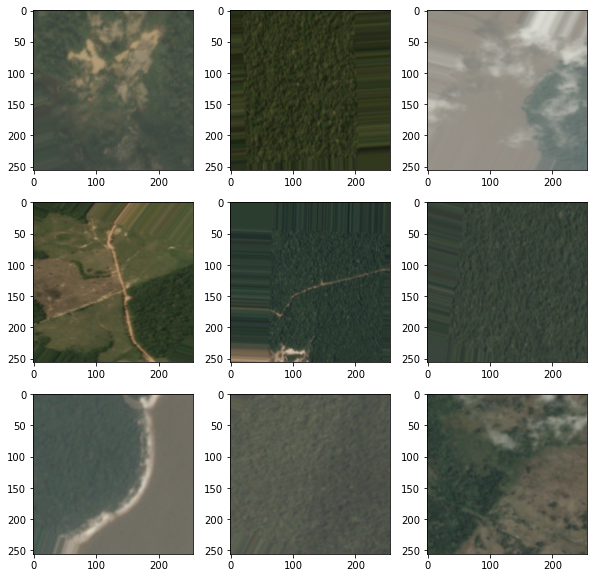

In [26]:
# See Example of image datagenerator
example = image_gen_train.flow_from_dataframe(dataframe=validation,
                                                    directory=images_folder_train,
                                                    x_col='image_name',
                                                    y_col=list_tags,
                                                    batch_size=batch_size, #16,32,64...
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="raw",
                                                    target_size=(width,width))

images, _ = next(example)
example_images = images[:9]
plot_images_datagen(axis=(3,3), images=example_images)

# Create Model
* <a href="https://arxiv.org/abs/1512.03385">Resnet </a>

In [27]:
# See if GPU is aviable
import tensorflow as tf

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Resnet50 Model

In [28]:
from tensorflow.keras import applications

# See model
applications.resnet50.ResNet50(weights= None).summary()

Metal device set to: Apple M1


2021-09-30 12:13:18.999566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-30 12:13:18.999668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

# Create model with Function

In [29]:
# Op 1:
from tensorflow.keras import applications
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

outs = len(list_tags)
def ResnetModel(outs = outs, freeze = False, pretrained = False):
    
    if pretrained:
        model_weights = 'imagenet'
    else:
        model_weights = None

    model = tf.keras.Sequential()
    model.add(applications.resnet50.ResNet50(weights= None, include_top=False, input_shape=(width,width,3)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(outs, activation= 'sigmoid'))


    if freeze:
        # Training only top layers i.e. the layers which we have added in the end
        # Indicate whether the first layer should be trained/changed or not.
        model.layers[0].trainable = False  
    
    return model

In [30]:
#model = ResnetModel(outs = outs, freeze = False, pretrained = False)
#model.summary()

# Create model with Class

In [31]:
# Op 2:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


class MyModel(tf.keras.Model):

    def __init__(self, n_outputs=outs, pretrained=False, freeze=False, size = width, depth = 3):
        
        super(MyModel, self).__init__()
        
           
        if pretrained:
            self.model_weights = 'imagenet'
        else:
            self.model_weights = None
        
        # Download the architecture of ResNet50 with ImageNet weights
        self.resnet = applications.resnet50.ResNet50(include_top=False, weights=self.model_weights, input_shape= (width,width, depth))
        
        # Taking the output of the last convolution block in ResNet50
        self.res_out = self.resnet.output
        self.res_in = self.resnet.input
        
        self.GlobPoll = GlobalAveragePooling2D()
        
        # Adding a fully connected layer having 1024 neurons
        #self.fc1 = Dense(1024, activation='relu')
        
        # Sigmoid Out
        self.out = Dense(outs, activation='sigmoid')
        
        if freeze:
            # Training only top layers i.e. the layers which we have added in the end
            self.resnet.trainable = False

    def call(self, inputs):

        x = self.resnet(inputs)
        x = self.GlobPoll(x)
        #x = self.fc1(x)
        x = self.out(x)
        
        return x


# Instance of Model with default values (No pretrain, No Freeze)

In [32]:
np.random.seed(1)
tf.random.set_seed(1234)

model = MyModel(pretrained=True, freeze=True)
#model.build(input_shape=(None,256, 256, 3))
#model.summary()
#model.layers[0].trainable


In [33]:
#np.random.seed(1)
#tf.random.set_seed(1234)

#model = ResnetModel()
#model.summary()

In [34]:
#model = MyModel()
#model.load_weights(PATH + 'Models/ModelResnet50_Epoch10/Resnet50_tf_batch32_NoPretrained_epoch10')

# Compile the Model

In [35]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['categorical_accuracy','accuracy'])

# Fit the model

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

STEP_SIZE_TRAIN = train_datagen.n//train_datagen.batch_size
STEP_SIZE_VALID = valid_datagen.n//valid_datagen.batch_size
STEP_SIZE_TEST = test_datagen.n//test_datagen.batch_size



# https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/Model#fit
model.fit(x = train_datagen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_datagen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=40,
                    callbacks=[monitor]
)


2021-08-23 10:26:55.232179: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-23 10:26:55.245993: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/40


2021-08-23 10:26:56.340082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1079/1079 [==============================] - ETA: 0s - loss: 0.3648 - categorical_accuracy: 0.6081 - accuracy: 0.6081

2021-08-23 10:36:26.027340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1079/1079 [==============================] - 631s 584ms/step - loss: 0.3648 - categorical_accuracy: 0.6081 - accuracy: 0.6081 - val_loss: 0.3633 - val_categorical_accuracy: 0.6106 - val_accuracy: 0.6106
Epoch 2/40
1079/1079 [==============================] - 661s 613ms/step - loss: 0.3593 - categorical_accuracy: 0.6110 - accuracy: 0.6110 - val_loss: 0.3551 - val_categorical_accuracy: 0.6106 - val_accuracy: 0.6106
Epoch 3/40
1079/1079 [==============================] - 671s 622ms/step - loss: 0.3554 - categorical_accuracy: 0.6109 - accuracy: 0.6109 - val_loss: 0.3526 - val_categorical_accuracy: 0.6087 - val_accuracy: 0.6087
Epoch 4/40
1079/1079 [==============================] - 735s 681ms/step - loss: 0.3530 - categorical_accuracy: 0.6108 - accuracy: 0.6108 - val_loss: 0.3515 - val_categorical_accuracy: 0.6092 - val_accuracy: 0.6092
Epoch 5/40
1079/1079 [==============================] - 792s 734ms/step - loss: 0.3506 - categorical_accuracy: 0.6108 - accuracy: 0.6108 - val_loss: 0.3552

# Test the model

In [37]:
# Predict 
#test_datagen.reset()
pred=model.predict_generator(test_datagen,
                            steps=STEP_SIZE_TEST,
                            verbose=1)


/Users/davidrestrepo/opt/anaconda3/envs/SeguridadAlimentaria_GPU/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
2021-08-23 15:29:11.333526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 120s 500ms/step


In [38]:
print('the predictions are: ')
pred

the predictions are: 


array([[0.54365766, 0.03212766, 0.13087183, ..., 0.97473997, 0.39151177,
        0.35410193],
       [0.45827538, 0.02925418, 0.14344259, ..., 0.9821853 , 0.32370046,
        0.29111254],
       [0.42120782, 0.02585863, 0.1353995 , ..., 0.98311824, 0.2747033 ,
        0.26417905],
       ...,
       [0.31123072, 0.02018701, 0.11959409, ..., 0.98600173, 0.14078851,
        0.1934787 ],
       [0.32146803, 0.0214345 , 0.1260743 , ..., 0.98615396, 0.16898689,
        0.1933559 ],
       [0.34806144, 0.0209096 , 0.12027572, ..., 0.9847109 , 0.1527674 ,
        0.22259624]], dtype=float32)

In [39]:
print('the predictions are: ')
# Transform predictions to 0 or 1
round_pred = np.rint(pred)
round_pred

the predictions are: 


array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [40]:
print('the actual values are: ')
y_true = test_datagen.labels
y_true[:round_pred.shape[0],:]

the actual values are: 


array([[1, 0, 0, ..., 1, 1, 0],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [41]:
#tags
list_tags

['agriculture',
 'bare_ground',
 'cultivation',
 'habitation',
 'primary',
 'road',
 'water']

In [42]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def get_metrics(y_true=y_true, round_pred=round_pred, column=0):

    print(f'The column is {list_tags[column]}')
    y_true = y_true[:round_pred.shape[0],column]
    round_pred = round_pred[:,column]
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, round_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_true, round_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, round_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, round_pred)
    print('F1 score: %f' % f1)

In [43]:
for i in range(len(list_tags)):
    print('---------')
    get_metrics(y_true, round_pred, i)
    print('---------')


---------
The column is agriculture
Accuracy: 0.674294
Precision: 0.431267
Recall: 0.065574
F1 score: 0.113838
---------
---------
The column is bare_ground
Accuracy: 0.979603
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
---------
---------
The column is cultivation
Accuracy: 0.885722
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
---------
---------
The column is habitation
Accuracy: 0.910303
Precision: 0.673077
Recall: 0.096953
F1 score: 0.169492
---------
---------
The column is primary
Accuracy: 0.976987
Precision: 0.976987
Recall: 1.000000
F1 score: 0.988360
---------
---------
The column is road
Accuracy: 0.798902
Precision: 0.638783
Recall: 0.104283
F1 score: 0.179296
---------
---------
The column is water
Accuracy: 0.805178
Precision: 0.423729
Recall: 0.016880
F1 score: 0.032468
---------


/Users/davidrestrepo/opt/anaconda3/envs/SeguridadAlimentaria_GPU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrestrepo/opt/anaconda3/envs/SeguridadAlimentaria_GPU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Save the model

In [44]:
# Save the weights (Class)
model.save_weights(PATH + 'Models/ModelResnet50_Pretrained/Resnet50_tf_batch32_Pretrained')
#model.save_weights(PATH + 'Models/ModelResnet50/Resnet50_tf_batch32_NoPretrained_epoch10')

In [75]:
# Save Model (function)
#model.save(PATH + 'Models/Resnet50_tf_batch32_NoPretrained.h5')

# Load the model

In [67]:
# Load moMyModelModelModell class
model2 = MyModel()
model2.load_weights(PATH+'Models/ModelResnet50_Pretrained/Resnet50_tf_batch32_Pretrained')
#model2.load_weights(PATH+'Models/ModelResnet50_Epoch10/Resnet50_tf_batch32_NoPretrained_epoch10')

#from tensorflow.keras.models import load_model
# Load Model (function) 
#new_model = load_model(PATH + 'Models/ModelVGG16/VGG16_tf_batch32_NoPretrained.h5')
#new_model.summary()

# Predictions

In [68]:
random = np.random.uniform(low=0.0, high=1.0, size=(1,256,256,3))
model.predict(random)

array([[0.10148496, 0.0047991 , 0.00148913, 0.9999881 , 0.5797755 ,
        0.999156  , 0.02957684]], dtype=float32)

In [ ]:
# Guardar el Modelo
#model.save(PATH + 'Models/Resnet50_tf_batch32_NoPretrained.h5')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________
